In [1]:
import pandas as pd

df = pd.read_csv("../../data/creditcard_clusters.csv")

In [2]:
X = df.drop(columns=['Class', 'cluster'])
clusters = df['cluster']
y_outliers = df['Class']

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

# Dividir os dados em treino (50%), validação (20%) e teste (30%)
X_train, X_temp, clusters_train, clusters_temp, y_train_outliers, y_temp_outliers = train_test_split(X, clusters, y_outliers, test_size=0.5, random_state=42, stratify=y_outliers)
X_val, X_test, clusters_val, clusters_test, y_val_outliers, y_test_outliers = train_test_split(X_temp, clusters_temp, y_temp_outliers, test_size=0.6, random_state=42, stratify=y_temp_outliers)

# Verificar tamanhos dos conjuntos
print(f"Tamanho do Conjunto de Treino: {X_train.shape[0]}")
print(f"Tamanho do Conjunto de Validação: {X_val.shape[0]}")
print(f"Tamanho do Conjunto de Teste: {X_test.shape[0]}")

Tamanho do Conjunto de Treino: 137831
Tamanho do Conjunto de Validação: 55132
Tamanho do Conjunto de Teste: 82700


In [17]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Função para criar e treinar um autoencoder para um cluster específico com hiperparâmetros variáveis
def train_autoencoder_with_params(X_cluster, encoding_dim, batch_size, epochs, learning_rate):
    input_dim = X_cluster.shape[1]
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(encoding_dim, activation='relu')(input_layer)
    decoder = Dense(input_dim, activation='sigmoid')(encoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    autoencoder.fit(X_cluster, X_cluster, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=0)
    return autoencoder

In [18]:
# Função para detectar outliers em um cluster
def detect_outliers(autoencoder, X_cluster, threshold=None):
    X_pred = autoencoder.predict(X_cluster)
    reconstruction_error = np.mean(np.square(X_cluster - X_pred), axis=1)
    if threshold is None:
        threshold = np.percentile(reconstruction_error, 95)  # Por exemplo, 95% dos dados de treino são considerados inliers
    outliers = reconstruction_error > threshold
    return outliers, reconstruction_error

In [19]:
# Função para aplicar o modelo e detectar outliers em novos dados
def apply_model(X_data, clusters_data, autoencoders, thresholds):
    outliers = np.zeros(len(X_data), dtype=bool)
    for cluster_id in np.unique(clusters_data):
        X_cluster = X_data[clusters_data == cluster_id]
        autoencoder = autoencoders[cluster_id]
        threshold = thresholds[cluster_id]
        cluster_outliers, _ = detect_outliers(autoencoder, X_cluster, threshold)
        outliers[clusters_data == cluster_id] = cluster_outliers
    return outliers

In [22]:
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

# Avaliar os modelos com diferentes combinações de hiperparâmetros
best_params = None
best_val_score = float('inf')

encoding_dims = [X_train.shape[1] // 4, X_train.shape[1] // 2, X_train.shape[1] // 3]
batch_sizes = [16, 32, 64, 128]
epochs = [5, 20, 50]

total_iterations = len(encoding_dims) * len(batch_sizes) * len(epochs)

with tqdm(total=total_iterations, desc="Total Progress") as pbar:
    for encoding_dim in tqdm(encoding_dims, desc="Encoding Dim Loop", leave=False):
        for batch_size in tqdm(batch_sizes, desc="Batch Size Loop", leave=False):
            for epoch in tqdm(epochs, desc="Epochs Loop", leave=False):
                autoencoders = {}
                thresholds = {}
                
                for cluster_id in np.unique(clusters_train):
                    X_cluster = X_train[clusters_train == cluster_id]
                    autoencoder = train_autoencoder_with_params(X_cluster, encoding_dim, batch_size, epoch)
                    autoencoders[cluster_id] = autoencoder
                    
                    # Determinar o threshold com base nos dados de treino
                    _, reconstruction_error = detect_outliers(autoencoder, X_cluster)
                    threshold = np.percentile(reconstruction_error, 95)  # Por exemplo, 95% dos dados de treino são considerados inliers
                    thresholds[cluster_id] = threshold
                
                # Avaliar no conjunto de validação
                outliers_val = apply_model(X_val, clusters_val, autoencoders, thresholds)
                val_score = mean_squared_error(y_val_outliers, outliers_val)
                
                # Atualizar os melhores hiperparâmetros
                if val_score < best_val_score:
                    best_val_score = val_score
                    best_params = (encoding_dim, batch_size, epoch)
                
                # Atualizar a barra de progresso total
                pbar.update(1)

print(f"Melhores Hiperparâmetros: Encoding Dim = {best_params[0]}, Batch Size = {best_params[1]}, Epochs = {best_params[2]}")

Total Progress:   0%|          | 0/36 [00:00<?, ?it/s]




275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 395us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 1s 400us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step


Total Progress:   3%|▎         | 1/36 [00:29<17:00, 29.14s/it]



275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 426us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 1s 425us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step


Total Progress:   6%|▌         | 2/36 [02:05<38:54, 68.67s/it]



275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 423us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 1s 457us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step


Total Progress:   8%|▊         | 3/36 [06:00<1:19:37, 144.78s/it]








275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 426us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step


Total Progress:  11%|█         | 4/36 [06:19<50:43, 95.11s/it]   



275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 417us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 1s 396us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step


Total Progress:  14%|█▍        | 5/36 [07:12<41:13, 79.80s/it]



275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 442us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 1s 444us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step


Total Progress:  17%|█▋        | 6/36 [09:22<48:29, 96.99s/it]








275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 513us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 1s 507us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step


Total Progress:  19%|█▉        | 7/36 [09:37<33:52, 70.09s/it]



275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 421us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 1s 420us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step


Total Progress:  22%|██▏       | 8/36 [10:10<27:08, 58.16s/it]



275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 450us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 1s 415us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step


Total Progress:  25%|██▌       | 9/36 [11:22<28:12, 62.70s/it]








275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 447us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 1s 443us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step


Total Progress:  28%|██▊       | 10/36 [11:34<20:18, 46.86s/it]



275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 423us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 1s 447us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step


Total Progress:  31%|███       | 11/36 [11:55<16:16, 39.05s/it]



275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 435us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 1s 424us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step


Total Progress:  33%|███▎      | 12/36 [12:37<15:57, 39.91s/it]










275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 422us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 1s 424us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step


Total Progress:  36%|███▌      | 13/36 [13:08<14:18, 37.34s/it]



275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 436us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 1s 430us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step


Total Progress:  39%|███▉      | 14/36 [14:51<20:52, 56.94s/it]



275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 455us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 1s 416us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step


Total Progress:  42%|████▏     | 15/36 [18:50<39:11, 111.98s/it]








275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 416us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 1s 413us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step


Total Progress:  44%|████▍     | 16/36 [19:09<28:01, 84.08s/it] 



275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 425us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 1s 409us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step


Total Progress:  47%|████▋     | 17/36 [20:05<23:53, 75.42s/it]



275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 456us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 1s 410us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step


Total Progress:  50%|█████     | 18/36 [22:18<27:51, 92.86s/it]








275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 453us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 1s 507us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step


Total Progress:  53%|█████▎    | 19/36 [22:32<19:36, 69.18s/it]



275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 422us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 1s 439us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step


Total Progress:  56%|█████▌    | 20/36 [23:04<15:26, 57.89s/it]



275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 408us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 1s 417us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step


Total Progress:  58%|█████▊    | 21/36 [24:13<15:21, 61.44s/it]








275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 423us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 1s 436us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step


Total Progress:  61%|██████    | 22/36 [24:24<10:46, 46.20s/it]



275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 410us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 2s 871us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step


Total Progress:  64%|██████▍   | 23/36 [24:47<08:29, 39.22s/it]



275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 425us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 1s 437us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step


Total Progress:  67%|██████▋   | 24/36 [25:28<07:57, 39.76s/it]










275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 1s 414us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step


Total Progress:  69%|██████▉   | 25/36 [25:59<06:47, 37.03s/it]



275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 418us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 1s 416us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step


Total Progress:  72%|███████▏  | 26/36 [27:42<09:27, 56.78s/it]



275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 414us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 1s 418us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step


Total Progress:  75%|███████▌  | 27/36 [31:40<16:41, 111.23s/it]








275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 424us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 1s 433us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step


Total Progress:  78%|███████▊  | 28/36 [31:59<11:07, 83.46s/it] 



275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 417us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 1s 422us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step


Total Progress:  81%|████████  | 29/36 [32:53<08:43, 74.80s/it]



275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 409us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 1s 419us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step


Total Progress:  83%|████████▎ | 30/36 [34:56<08:56, 89.36s/it]








275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 421us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 1s 422us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step


Total Progress:  86%|████████▌ | 31/36 [35:09<05:32, 66.44s/it]



275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 402us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 1s 410us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step


Total Progress:  89%|████████▉ | 32/36 [35:40<03:42, 55.70s/it]



275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 431us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 1s 410us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step


Total Progress:  92%|█████████▏| 33/36 [36:47<02:57, 59.09s/it]








275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 407us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 1s 419us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step


Total Progress:  94%|█████████▍| 34/36 [36:57<01:28, 44.44s/it]



275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 411us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 1s 406us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step


Total Progress:  97%|█████████▋| 35/36 [37:17<00:37, 37.15s/it]



275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 411us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 1s 412us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step


Total Progress: 100%|██████████| 36/36 [37:57<00:00, 37.97s/it]





Total Progress: 100%|██████████| 36/36 [37:57<00:00, 63.27s/it]

Melhores Hiperparâmetros: Encoding Dim = 9, Batch Size = 16, Epochs = 5


In [23]:
# Treinar o modelo final com os melhores hiperparâmetros
autoencoders = {}
thresholds = {}

for cluster_id in np.unique(clusters_train):
    X_cluster = X_train[clusters_train == cluster_id]
    autoencoder = train_autoencoder_with_params(X_cluster, best_params[0], best_params[1], best_params[2])
    autoencoders[cluster_id] = autoencoder
    
    # Determinar o threshold com base nos dados de treino
    _, reconstruction_error = detect_outliers(autoencoder, X_cluster)
    threshold = np.percentile(reconstruction_error, 95)  # Por exemplo, 95% dos dados de treino são considerados inliers
    thresholds[cluster_id] = threshold

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 1s 397us/step
2229/2229 ━━━━━━━━━━━━━━━━━━━━ 1s 416us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step


In [24]:
# Detectar outliers no conjunto de teste
outliers_test = apply_model(X_test, clusters_test, autoencoders, thresholds)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step
818/818 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step


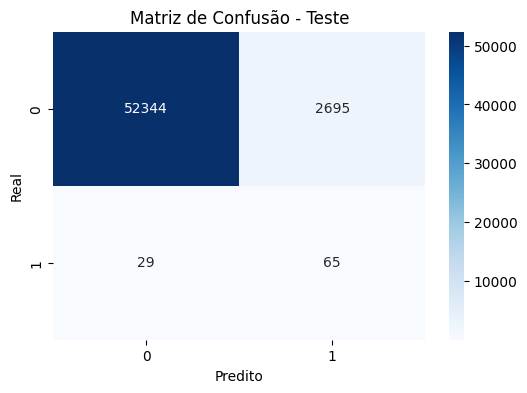

In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizar a matriz de confusão
def plot_confusion_matrix(y_true, y_pred, title='Matriz de Confusão'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test_outliers, outliers_test, title='Matriz de Confusão - Teste')